In [3]:
import yfinance as yf
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import scipy.stats as sps
import pmdarima as arima
from arch import arch_model

In [24]:
spy = yf.download("SPY", start="2010-01-01", end="2025-05-17")
time.sleep(5)
nvda = yf.download("NVDA", start="2010-01-01", end="2025-05-17")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [25]:
x = yf.download("X",start="2010-01-01", end="2025-05-17")
x.to_csv("x.csv")

[*********************100%***********************]  1 of 1 completed


In [26]:
nvda.to_csv('nvda.csv')
spy.to_csv('spy.csv')

In [27]:
print(nvda.shape)
print(nvda.columns)
print(spy.columns)

(3867, 5)
MultiIndex([( 'Close', 'NVDA'),
            (  'High', 'NVDA'),
            (   'Low', 'NVDA'),
            (  'Open', 'NVDA'),
            ('Volume', 'NVDA')],
           names=['Price', 'Ticker'])
MultiIndex([( 'Close', 'SPY'),
            (  'High', 'SPY'),
            (   'Low', 'SPY'),
            (  'Open', 'SPY'),
            ('Volume', 'SPY')],
           names=['Price', 'Ticker'])


In [28]:
print(spy.iloc[0].shape)
print(2*3774*2)

(5,)
15096


In [4]:
def load_data(file):
    xdat = pd.read_csv(file,skiprows=2)

    xdat.columns = ['Date','Close','High','Low','Open','Volume']
    xdat['Date'] = pd.to_datetime(xdat['Date'])
    
    return xdat

In [5]:
def plot_data(xdat:pd.DataFrame):
    plt.plot(xdat['Date'],xdat['Close'])
    plt.title("Prices")
    plt.show()

    xdat['logReturns'] = np.log1p(xdat.Close).diff()
    xdat['Squared_logReturns'] = (xdat.logReturns)**2

    plt.plot(xdat['Date'],xdat['logReturns'])
    plt.title("log-Returns")
    plt.show()

    plt.plot(xdat['Date'],xdat['Squared_logReturns'])
    plt.title("Squared log-Returns")
    plt.show()

# Asset 1

           Date      Close       High        Low       Open     Volume
3517 2023-12-22  48.811672  49.364462  48.448806  49.176533  252507000
3518 2023-12-26  49.260498  49.581377  48.941618  48.949614  244200000
3519 2023-12-27  49.398445  49.661347  49.066569  49.492412  233648000
3520 2023-12-28  49.503410  49.865274  49.393451  49.624367  246587000
3521 2023-12-29  49.503410  49.978234  48.732700  49.794301  389293000


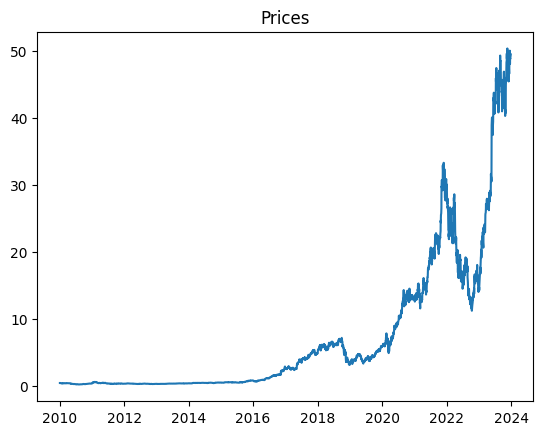

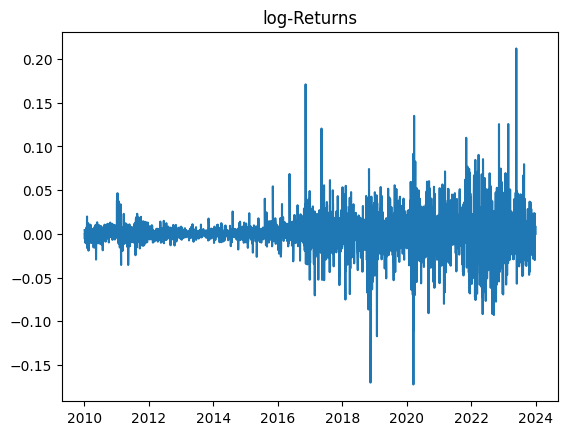

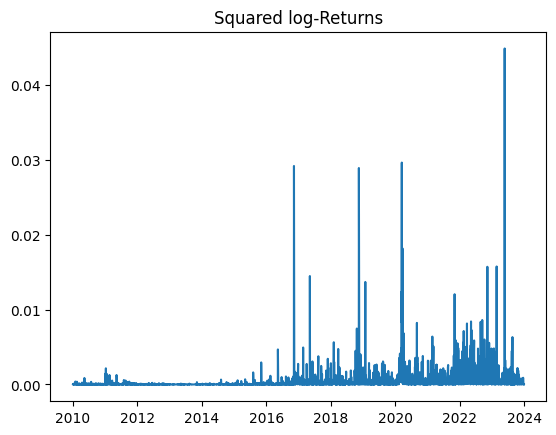

In [6]:
ticket = "nvda"
nvda = load_data(ticket + ".csv")
nvda = nvda[nvda['Date'] <= '2023-12-31']
print(nvda.tail())
plot_data(nvda)

# Asset 2

        Date      Close       High        Low       Open     Volume
0 2010-01-04  85.768448  85.813854  84.391067  85.041918  118944600
1 2010-01-05  85.995491  86.033333  85.405186  85.715478  111579900
2 2010-01-06  86.056046  86.267949  85.844142  85.912251  116074400
3 2010-01-07  86.419304  86.525256  85.654932  85.897108  131091100
4 2010-01-08  86.706863  86.744706  86.018176  86.192237  126402800


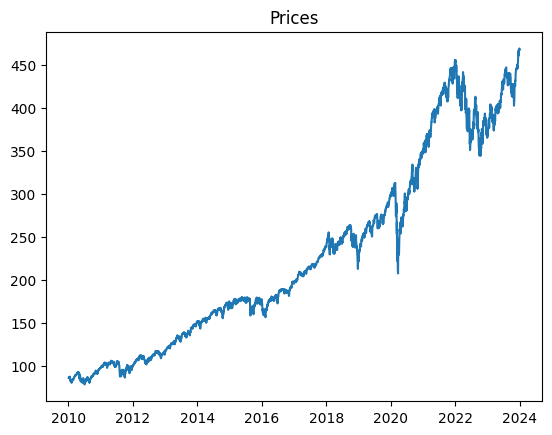

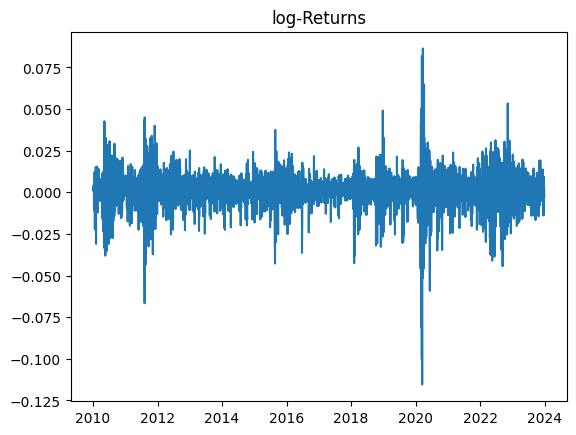

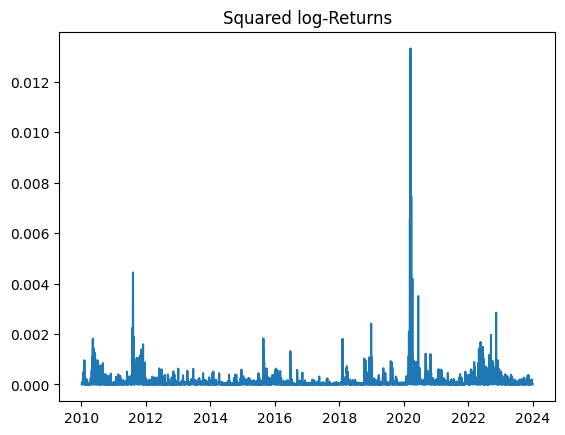

In [7]:
ticket = "spy"
spy = load_data(ticket+".csv")
spy = spy[spy['Date'] <= '2023-12-31']
print(spy.head())
plot_data(spy)

# Risk Comparison

In [8]:
def get_dataset(data, train: bool):
    if train:
        return data[data['Price'] <= '2023-12-31']
    else:
        return data[data['Price'] > '2023-12-31']

def compute_returns(data: pd.DataFrame):
    prices = data["Close"]
    returns = (prices / prices.shift(1)) - 1
    returns = returns.fillna(0)
    return returns

In [9]:
x = pd.read_csv("x.csv",skiprows=[1,2])
data = get_dataset(x,train=True)
x_r = compute_returns(data)

In [10]:
spy = pd.read_csv("spy.csv",skiprows=[1,2])
data = get_dataset(spy,train=True)
spy_r = compute_returns(data)

In [11]:
nvda = pd.read_csv("nvda.csv",skiprows=[1,2])
data = get_dataset(nvda,train=True)
nvda_r = compute_returns(data)

In [12]:
mean_spy=spy_r.expanding().mean()
mean_x=x_r.expanding().mean()
mean_nvda=nvda_r.expanding().mean()

var_spy=spy_r.expanding().var()
var_x=x_r.expanding().var()
var_nvda=nvda_r.expanding().var()

print("NaN in mean_spy:", mean_spy.isna().sum())
print("NaN in mean_x:", mean_x.isna().sum())
print("NaN in mean_nvda:", mean_nvda.isna().sum())

print("Length of mean_spy:", len(mean_spy))
print("Length of mean_x:", len(mean_x))
print("Length of mean_nvda:", len(mean_nvda))

NaN in mean_spy: 0
NaN in mean_x: 0
NaN in mean_nvda: 0
Length of mean_spy: 3522
Length of mean_x: 3522
Length of mean_nvda: 3522


In [13]:
b = mean_spy>mean_x
print(np.sum(b)/len(b))

b2 = var_spy>var_x
print(np.sum(b2)/len(b2))

0.9642248722316865
0.00028392958546280523


In [14]:
b = mean_spy>mean_nvda 
print(np.sum(b)/len(b))

b2 = var_spy>var_nvda
print(np.sum(b2)/len(b2))

0.3940942646223736
0.0


In [15]:
b = mean_nvda>mean_x 
print(np.sum(b)/len(b))

b2 = var_nvda>var_x 
print(np.sum(b2)/len(b2))

0.9327086882453152
0.049403747870528106


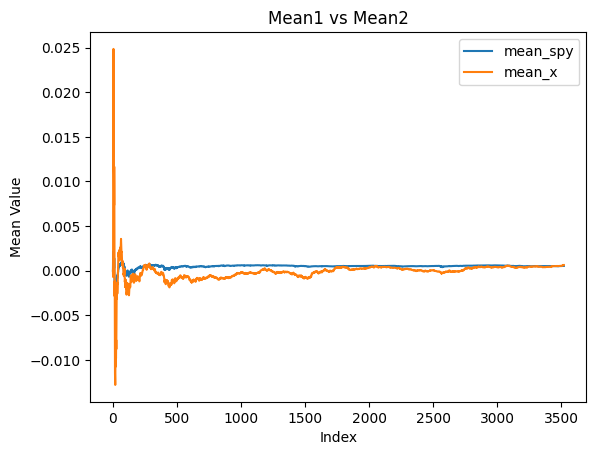

In [16]:
plt.plot(mean_spy, label='mean_spy')
plt.plot(mean_x, label='mean_x')
plt.title('Mean1 vs Mean2')
plt.xlabel('Index')
plt.ylabel('Mean Value')
plt.legend()
plt.show()

# Minimum Variance Portfolio

In [17]:
def get_mvp(var1,var2,cov):
    std1 = torch.sqrt(var1)
    std2 = torch.sqrt(var2)
    corr = cov/(std1*std2)
    nom = var2 - (corr*std1*std2)
    den = var1 + var2 - (2*corr*std1*std2)
    return nom/den

def get_capital_values(capital,w):
    return w * capital, (1-w)*capital

def get_return_values(returns,w):
    return w * returns + (1-w)*returns

$$\text{VaR}_\alpha = \mu + \sigma \Phi^{-1}(1-\alpha)$$

In [18]:
def get_VaR(alpha, mean, std):
    VaR = mean + (std*sps.norm.ppf(q=1-alpha,loc=0,scale=1))
    return VaR

def get_ES(alpha, mean, std):
    levels5 = np.linspace(0.001,1-alpha,40)
    q5 = sps.norm.ppf(levels5, 0, 1)
    mean5 = q5.mean()
    return mean + std*(mean5)

In [19]:
spy_test = get_dataset(spy,train=False)
spy_test_r = compute_returns(spy_test)

nvda_test = get_dataset(nvda,train=False)
nvda_test_r = compute_returns(nvda_test)

In [125]:
spy_r_log = (np.log1p(spy_r))
spy_r_squared = (np.log1p(spy_r))**2

nvda_r_log = (np.log1p(nvda_r))
nvda_r_squared = (np.log1p(nvda_r))**2

spy_test_r_log = (np.log1p(spy_test_r))
spy_test_r_squared = (np.log1p(spy_test_r))**2

nvda_test_r_log = (np.log1p(nvda_test_r))
nvda_test_r_squared = (np.log1p(nvda_test_r))**2

trading_days_2024 = pd.bdate_range(start='2024-01-01', end='2024-12-31')
start_2025_index = len(trading_days_2024)

train_length = len(spy_r_log)
test_length = len(spy_test_r_log)

assert len(spy_r_log) == len(spy_r_squared) == len(nvda_r_log) == len(nvda_r_squared), "Train sets do not have the same length"
assert len(spy_test_r_log) == len(spy_test_r_squared) == len(nvda_test_r_log) == len(nvda_test_r_squared), "Test sets do not have the same length"

# ARMA

$$Y_t = \phi_0 + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \cdots + \phi_p Y_{t-p} + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \cdots + \theta_q \epsilon_{t-q}$$
$$ \epsilon_t \sim N(0, \sigma^2)$$

In [21]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [220]:
def get_ARMA(returns):
    arma_model = arima.AutoARIMA(d=0,information_criterion="bic",suppress_warnings=True,trace=True)
    arma_model.fit(y=returns)
    return arma_model

def get_ARMA_predictions(arma_model,test_returns):
    arma_model.update(test_returns)
    prediction = arma_model.predict_in_sample()
    return prediction

def compute_VaR_ES(mean,variance,asset):

    train_VaR = get_VaR(alpha=0.95, mean=mean[:train_length], std=variance[:train_length]**0.5)
    test_VaR = get_VaR(alpha=0.95, mean=mean[-test_length:], std=variance[-test_length:]**0.5)
    print("Train SPY VaR:")
    print(np.asarray(train_VaR)[~np.isnan(train_VaR)].mean())
    print("Test SPY VaR:")
    print(np.asarray(test_VaR)[~np.isnan(test_VaR)].mean())

    train_ES = get_ES(alpha=0.95, mean=mean[:train_length], std=variance[:train_length]**0.5)
    test_ES = get_ES(alpha=0.95, mean=mean[-test_length:], std=variance[-test_length:]**0.5)
    print("Train "+asset+" ES:")
    print(np.asarray(train_ES)[~np.isnan(train_ES)].mean())
    print("Test "+asset+" ES:")
    print(np.asarray(test_ES)[~np.isnan(test_ES)].mean())

    assert len(train_VaR) == train_length, "Train VaR length mismatch"
    assert len(test_VaR) == test_length, "Test VaR length mismatch"
    assert len(train_ES) == train_length, "Train ES length mismatch"
    assert len(test_ES) == test_length, "Test ES length mismatch"

    return train_VaR, test_VaR, train_ES, test_ES

def compute_backtest_results(train_returns, test_returns, train_VaR, test_VaR):
    print(f"Train VaR coverage: {(np.where((train_returns <= train_VaR), 1, 0)).mean():.4f}")
    print(f"Test VaR coverage: {(np.where((test_returns <= test_VaR), 1, 0)).mean():.4f}")

    test_returns_2024 = test_returns.iloc[:start_2025_index]
    test_VaR_2024 = test_VaR[:start_2025_index]

    test_returns_2025 = test_returns.iloc[start_2025_index:]
    test_VaR_2025 = test_VaR[start_2025_index:]

    print(f"Test VaR coverage (2024): {(np.where((test_returns_2024 <= test_VaR_2024), 1, 0)).mean():.4f}")
    print(f"Test VaR coverage (2025): {(np.where((test_returns_2025 <= test_VaR_2025), 1, 0)).mean():.4f}")
    

def plot_train_VaR_ES(asset, train_returns, train_VaR, train_ES):
    tail = test_length
    n = train_length
    date_range = asset['Price'].iloc[n-tail:n]
    plt.figure(figsize=(14, 6))
    plt.plot(date_range, train_returns.iloc[-tail:], label='Log Returns')
    plt.plot(date_range, train_VaR[-tail:], label='VaR95')
    plt.plot(date_range, train_ES[-tail:], label='ES95')
    plt.title(f"VaR and ES (Last {tail} Train Data)")
    plt.xlabel("Date")

    step = max(1, len(date_range) // 20)
    plt.xticks(ticks=np.arange(0, len(date_range), step), labels=date_range.iloc[::step], rotation=45)

    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_test_VaR_ES(asset, test_returns, test_VaR, test_ES):
    tail = test_length
    n = test_length
    date_range = asset['Price'].iloc[-tail:]

    plt.figure(figsize=(14, 6))
    plt.plot(date_range, test_returns.iloc[-tail:], label='Log Returns')
    plt.plot(date_range, test_VaR[-tail:], label='VaR95')
    plt.plot(date_range, test_ES[-tail:], label='ES95')
    plt.axvline(x=start_2025_index, color='red', linestyle='--', label='Start of 2025')
    plt.title(f"VaR and ES (Test Data)")
    plt.xlabel("Date")

    step = max(1, len(date_range) // 20)
    plt.xticks(ticks=np.arange(0, len(date_range), step), labels=date_range.iloc[::step], rotation=45)

    plt.legend()
    plt.tight_layout()
    plt.show()

In [140]:
spy_arma = get_ARMA(spy_r_squared)
print(spy_arma.summary())

Performing stepwise search to minimize bic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : BIC=-45875.486, Time=1.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=-44459.232, Time=0.29 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : BIC=-45186.198, Time=0.63 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : BIC=-44824.485, Time=0.97 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-44212.573, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : BIC=-45785.197, Time=0.66 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : BIC=-45879.160, Time=1.31 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : BIC=-45658.791, Time=1.10 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : BIC=-45877.462, Time=0.73 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : BIC=-45870.195, Time=0.75 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : BIC=-45878.566, Time=1.71 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : BIC=-45797.785, Time=2.16 sec
 ARIMA(2,0,1)(0,0,0)[0]             : BIC=-45854.946, Time=0.63 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 12.247 sec

In [141]:
spy_variance = get_ARMA_predictions(spy_arma,spy_test_r_squared)

In [175]:
zero_mean = np.zeros(train_length + test_length)
train_spy_VaR, test_spy_VaR, train_spy_ES, test_spy_ES = compute_VaR_ES(zero_mean, spy_variance, "SPY")

Train SPY VaR:
-0.015622459324428831
Test SPY VaR:
-0.015666601921080926
Train SPY ES:
-0.019423945112591788
Test SPY ES:
-0.01947882913287897


In [176]:
compute_backtest_results(spy_r_log, spy_test_r_log, train_spy_VaR, test_spy_VaR)

Train VaR coverage: 0.0591
Test VaR coverage: 0.0580
Test VaR coverage (2024): 0.0458
Test VaR coverage (2025): 0.0964


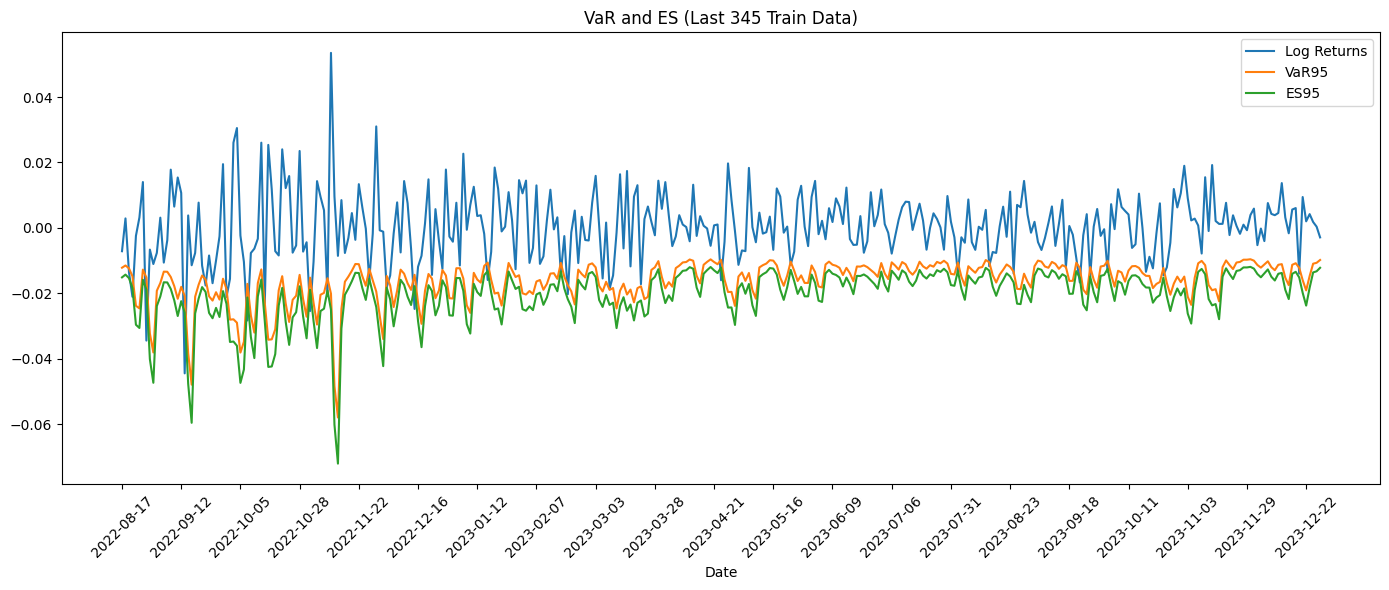

In [218]:
plot_train_VaR_ES(spy, spy_r_log, train_spy_VaR, train_spy_ES)

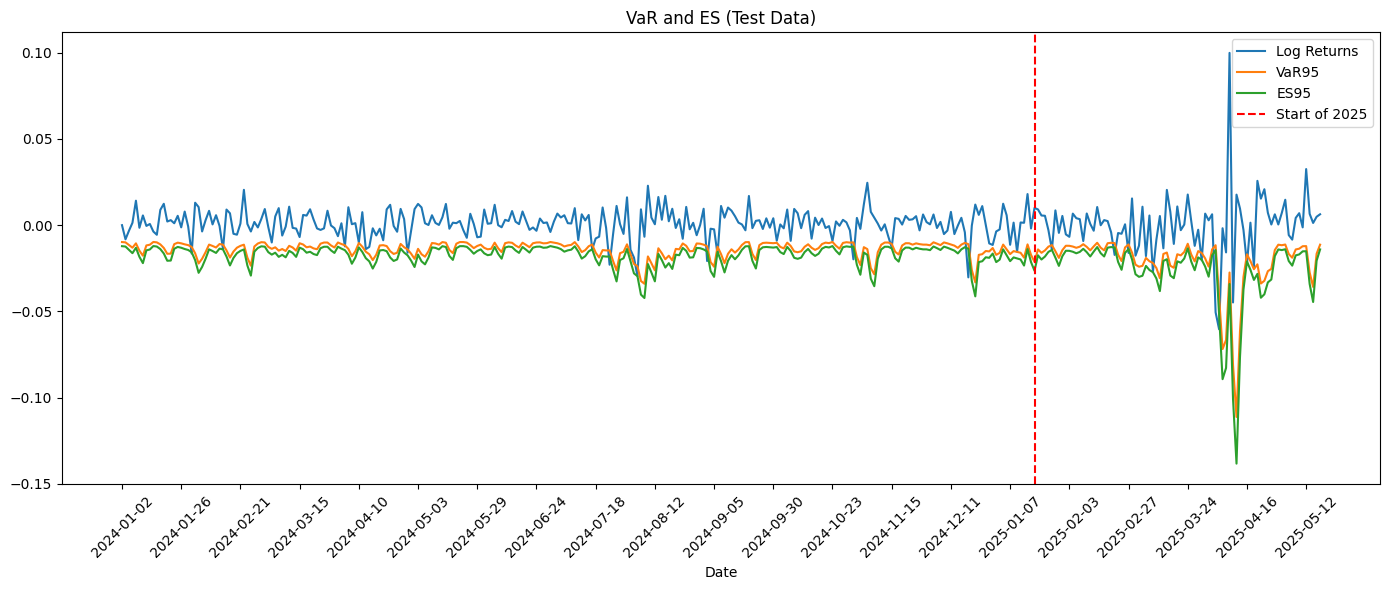

In [219]:
plot_test_VaR_ES(spy, spy_test_r_log, test_spy_VaR, test_spy_ES)

# GARCH

$$\sigma_t^2 = \omega + \alpha_1 \epsilon_{t-1}^2 + \alpha_2 \epsilon_{t-2}^2 + \cdots + \alpha_p \epsilon_{t-p}^2 + \beta_1 \sigma_{t-1}^2 + \beta_2 \sigma_{t-2}^2 + \cdots + \beta_q \sigma_{t-q}^2$$
$$\sigma_t^2 = \omega + \sum_{i=1}^{p} \alpha_i \epsilon_{t-i}^2 + \sum_{j=1}^{q} \beta_j \sigma_{t-j}^2$$

In [221]:
from sklearn.preprocessing import StandardScaler
scaler_spy_r_log = StandardScaler()
spy_r_log_s = scaler_spy_r_log.fit_transform(spy_r_log.values.reshape(-1, 1)).flatten()
spy_test_r_log_s = scaler_spy_r_log.transform(spy_test_r_log.values.reshape(-1, 1)).flatten()

spy_r_log_s = pd.Series(spy_r_log_s, index=spy_r_log.index)
spy_test_r_log_s = pd.Series(spy_test_r_log_s, index=spy_test_r_log.index)

In [222]:
def get_GARCH(train_returns,test_returns,arma_p,arma_q,rescale):
    distributions = ['normal', 't', 'skewt']
    best_metric = np.inf
    best_model = None

    for dist in distributions:
        for p in range(1, 3):
            for q in range(1, 3):
                model = arch_model(train_returns, vol='GARCH', p=p, q=q, mean="ARX", lags=[arma_q, arma_p], dist=dist, rescale=rescale)
                res = model.fit(disp='off',update_freq=0, cov_type="robust")
                if res.bic < best_metric:
                    best_metric = res.bic
                    best_model = res
                    best_config = (p, q, dist)
                print(f"Try: p={p}, q={q}, dist={dist}, BIC={res.bic:.2f}")

    print("Best config:", best_config)
    print("Best BIC:", best_metric)

    update_model = arch_model(np.concatenate([train_returns,test_returns]), vol='GARCH',
                            p=best_config[0], q=best_config[1], mean="ARX", lags=[arma_q, arma_p], dist=best_config[2], rescale=rescale)
    update_res = update_model.fit(starting_values=best_model.params,disp='off',update_freq=0, cov_type="robust")
    return update_res

In [223]:
def get_GARCH_prediction(garch_result):

    resid = garch_result.std_resid * garch_result.conditional_volatility
    mean = garch_result.model.y - resid

    variance = garch_result.conditional_volatility ** 2

    return mean, variance

In [224]:
garch_res = get_GARCH(spy_r_log_s,spy_test_r_log_s, arma_p=2, arma_q=1, rescale=False)

Try: p=1, q=1, dist=normal, BIC=8451.19
Try: p=1, q=2, dist=normal, BIC=8459.36
Try: p=2, q=1, dist=normal, BIC=8455.36
Try: p=2, q=2, dist=normal, BIC=8462.75
Try: p=1, q=1, dist=t, BIC=8261.40
Try: p=1, q=2, dist=t, BIC=8269.57
Try: p=2, q=1, dist=t, BIC=8262.17
Try: p=2, q=2, dist=t, BIC=8269.62
Try: p=1, q=1, dist=skewt, BIC=8233.07
Try: p=1, q=2, dist=skewt, BIC=8241.24
Try: p=2, q=1, dist=skewt, BIC=8232.28
Try: p=2, q=2, dist=skewt, BIC=8239.69
Best config: (2, 1, 'skewt')
Best BIC: 8232.277859341591


In [225]:
print("GARCH model summary:")
print(garch_res.summary())

GARCH model summary:
                                 AR - GARCH Model Results                                
Dep. Variable:                                 y   R-squared:                       0.001
Mean Model:                                   AR   Adj. R-squared:                  0.001
Vol Model:                                 GARCH   Log-Likelihood:               -4494.86
Distribution:      Standardized Skew Student's t   AIC:                           9007.72
Method:                       Maximum Likelihood   BIC:                           9064.06
                                                   No. Observations:                 3865
Date:                           Sat, May 24 2025   Df Residuals:                     3862
Time:                                   18:53:07   Df Model:                            3
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
-----------

In [226]:
garch_mean,garch_variance = get_GARCH_prediction(garch_res)

print("NaN count in garch_mean:", np.isnan(garch_mean).sum())
print("NaN count in garch_variance:", np.isnan(garch_variance).sum())

print("Length of garch_mean:", len(garch_mean))
print("Length of garch_variance:", len(garch_variance))

NaN count in garch_mean: 2
NaN count in garch_variance: 2
Length of garch_mean: 3867
Length of garch_variance: 3867


In [227]:
garch_train_spy_VaR, garch_test_spy_VaR, garch_train_spy_ES, garch_test_spy_ES = compute_VaR_ES(garch_mean, garch_variance, "SPY")

Train SPY VaR:
-1.4255699333848528
Test SPY VaR:
-1.4550025481477433
Train SPY ES:
-1.7799117990465256
Test SPY ES:
-1.8160447198516436


In [228]:
compute_backtest_results(spy_r_log_s, spy_test_r_log_s, garch_train_spy_VaR, garch_test_spy_VaR)

Train VaR coverage: 0.0605
Test VaR coverage: 0.0667
Test VaR coverage (2024): 0.0573
Test VaR coverage (2025): 0.0964


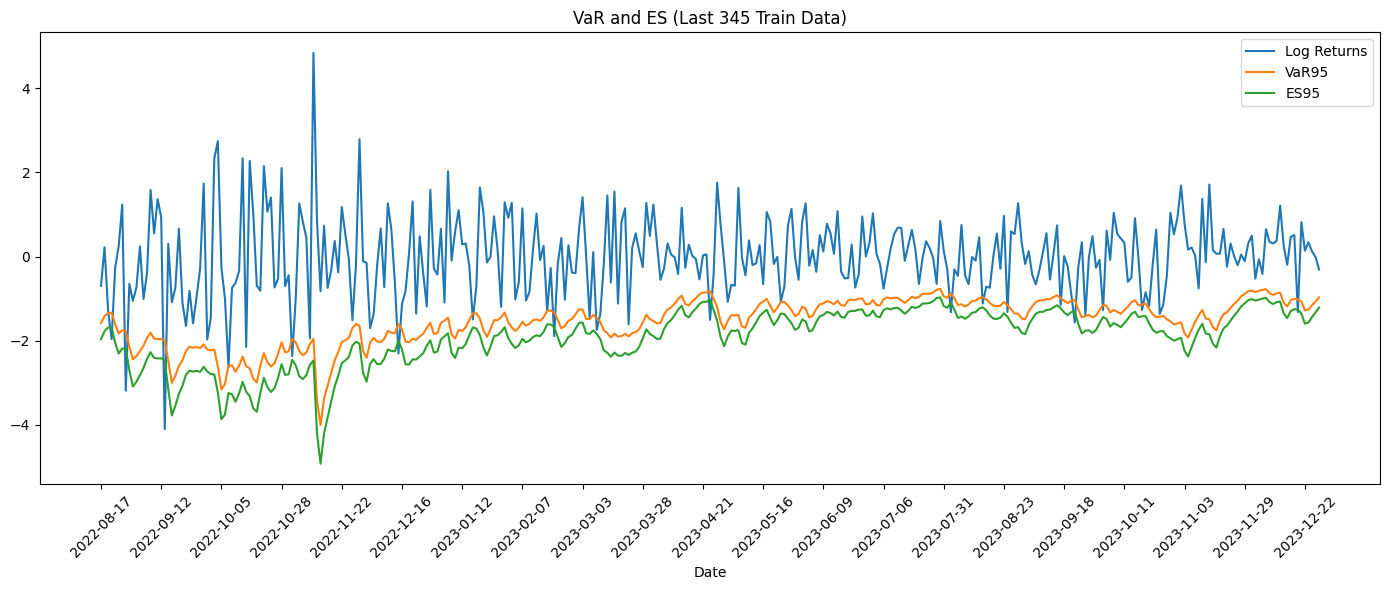

In [229]:
plot_train_VaR_ES(spy, spy_r_log_s, garch_train_spy_VaR, garch_train_spy_ES)

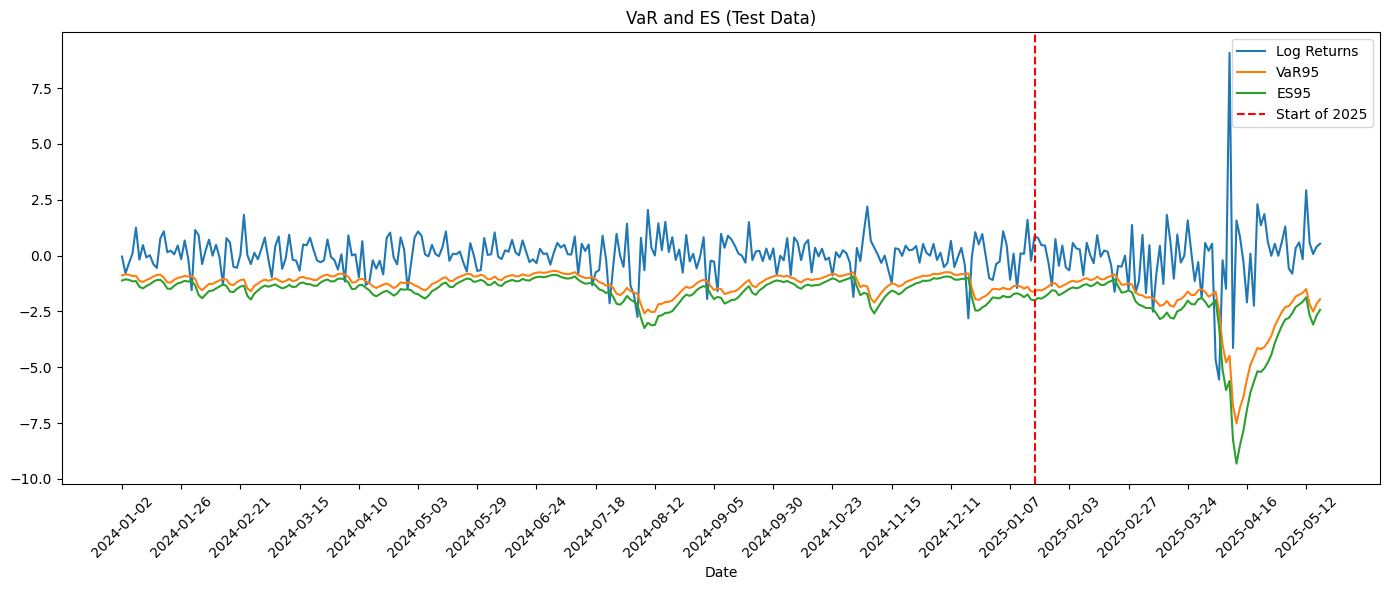

In [233]:
plot_test_VaR_ES(spy, spy_test_r_log_s, garch_test_spy_VaR, garch_test_spy_ES)